## 언어 분류

목    적 => 알파벳(a~z)을 사용하는 언어 식별  
데 이 터 => 알파벳 사용하는 4개국의 텍스트 파일  
전제조건 => 나라별 자주 사용되는 알파벳이 다름!  

In [79]:
# 모듈 로딩
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [80]:
import warnings

warnings.filterwarnings(action='ignore')

(1) 전처리
- 나라별 알파벳 패턴 분석

In [81]:
# a-z 카운팅 함수
def countAlpabet(type):
    country = ['en','fr','id','tl']
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    check_list = []
    labels = []
    j = 1

    for c in country:
        if type == 'train':
            for _ in range(1,6):
                file = open('./lang/{}/{}-{}.txt'.format(type, c,j), 'r', encoding='utf-8')
                data = file.read().lower()
                count = [0] * 26

                for a in data:
                    if a in alphabet:
                        i = alphabet.find(a)
                        count[i] += 1
                check_list.append(count)
                labels.append(c)
                j +=1
        
        elif type == 'test':
            for _ in range(1,3):
                file = open('./lang/{}/{}-{}.txt'.format(type, c,j), 'r', encoding='utf-8')
                data = file.read().lower()
                count = [0] * 26

                for a in data:
                    if a in alphabet:
                        i = alphabet.find(a)
                        count[i] += 1
                check_list.append(count)
                labels.append(c)
                j +=1
                    
        file.close()
        df = pd.DataFrame(check_list, columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
        df['label'] = labels
        df.to_csv('alphabet_{}.csv'.format(type))

countAlpabet('train')
countAlpabet('test')

In [82]:
train_input = pd.read_csv('./alphabet_train.csv')
test_input = pd.read_csv('./alphabet_test.csv')

In [83]:
train_X = train_input.iloc[:,1:27]
test_X = test_input.iloc[:,1:27]
train_y = train_input.iloc[:,27:28]
test_y = test_input.iloc[:,27:28]

In [84]:
# 비율 맞춰 줌
for i in range(20):
    train_X.iloc[i] = train_X.iloc[i]/sum(train_X.iloc[i])
for i in range(8):
    test_X.iloc[i] = test_X.iloc[i]/sum(test_X.iloc[i])

(2) 학습
- 교차 검증

In [192]:
# 모델 객체 생성
model = LogisticRegression(max_iter=5)

In [193]:
# 기본: 5-Fold 학습/검증 모델 생성 진행
result = cross_validate(model, train_X, train_y, return_train_score=True)

In [194]:
result

{'fit_time': array([0.0089767 , 0.00697994, 0.00598216, 0.00698161, 0.00598431]),
 'score_time': array([0.00299215, 0.00299668, 0.00099778, 0.00199437, 0.00299358]),
 'test_score': array([1.  , 0.75, 0.75, 0.75, 0.75]),
 'train_score': array([0.8125, 0.8125, 0.8125, 0.875 , 0.8125])}

In [195]:
print('train score: {}, test score: {}'.format(result['train_score'].mean(), result['test_score'].mean()))

train score: 0.825, test score: 0.8


- 로지스틱 회귀

In [168]:
# 모델 객체 생성
model = LogisticRegression(max_iter=2)

In [169]:
model.fit(train_X, train_y)

LogisticRegression(max_iter=2)

In [170]:
print('train score: {}, test score: {}'.format(model.score(train_X, train_y), model.score(test_X, test_y)))

train score: 0.85, test score: 0.875


In [191]:
y_pred = model.predict(test_X)
y_pred

array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype=object)

In [172]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
ac = accuracy_score(test_y, y_pred)
cm = confusion_matrix(test_y, y_pred)

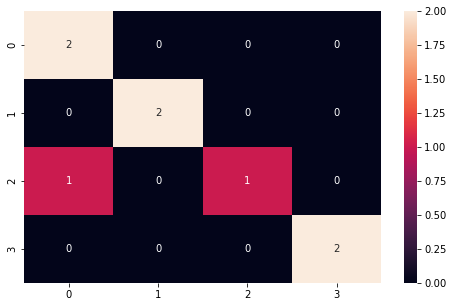

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot = True)
plt.show()

- 랜덤포레스트

In [174]:
from sklearn.ensemble import RandomForestClassifier

In [187]:
forestModel = RandomForestClassifier(max_depth=5)

In [188]:
forestModel.fit(train_X, train_y)

RandomForestClassifier(max_depth=5)

In [189]:
# 모델 학습 후 속성
print('classes_: {}'.format(forestModel.classes_))

classes_: ['en' 'fr' 'id' 'tl']


In [190]:
print('train score: {}, test score: {}'.format(forestModel.score(train_X, train_y), forestModel.score(test_X, test_y)))

train score: 1.0, test score: 1.0


In [197]:
y_pred = forestModel.predict(test_X)
y_pred

array(['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl'], dtype=object)

- all_estimators() 확인

In [100]:
from sklearn.utils import all_estimators
import numpy as np

In [101]:
# 필터 타입에 해당하는 sklearn에 존재하는 모든 모델 이름과 객체 리스트로 반환
models = all_estimators(type_filter='classifier')

In [102]:
scores = []
names = []

for name, model in models:
    try:
        # 모델 객체 생성
        md = model()
        # 학습
        md.fit(train_X, train_y)
        # 평가
        result = md.score(test_X, test_y)
        names.append(name)
        scores.append((name, np.round(result,3)))
    except:
        pass

In [201]:
scores

[('AdaBoostClassifier', 0.625),
 ('BaggingClassifier', 0.75),
 ('BernoulliNB', 0.25),
 ('CalibratedClassifierCV', 0.875),
 ('CategoricalNB', 0.25),
 ('ComplementNB', 0.5),
 ('DecisionTreeClassifier', 0.625),
 ('DummyClassifier', 0.25),
 ('ExtraTreeClassifier', 0.875),
 ('ExtraTreesClassifier', 1.0),
 ('GaussianNB', 0.75),
 ('GaussianProcessClassifier', 0.75),
 ('GradientBoostingClassifier', 1.0),
 ('HistGradientBoostingClassifier', 0.25),
 ('KNeighborsClassifier', 0.75),
 ('LabelPropagation', 1.0),
 ('LabelSpreading', 1.0),
 ('LinearDiscriminantAnalysis', 0.875),
 ('LinearSVC', 0.75),
 ('LogisticRegression', 0.75),
 ('LogisticRegressionCV', 1.0),
 ('MLPClassifier', 1.0),
 ('MultinomialNB', 0.625),
 ('NearestCentroid', 1.0),
 ('NuSVC', 1.0),
 ('PassiveAggressiveClassifier', 0.5),
 ('Perceptron', 0.5),
 ('QuadraticDiscriminantAnalysis', 0.25),
 ('RadiusNeighborsClassifier', 0.25),
 ('RandomForestClassifier', 1.0),
 ('RidgeClassifier', 0.75),
 ('RidgeClassifierCV', 0.875),
 ('SGDClassifie